In [ ]:
# !pip install numpy pandas matplotlib scikit-learn tensorflow joblib

In [ ]:
# Enable GPU optiomization for Apple Sillicon

import tensorflow as tf

# Set GPU as the default device for all operations
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Set GPU as default device
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f"Using GPU: {gpus[0]}")

    except RuntimeError as e:
        print(f"Error setting GPU: {e}")

# Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

In [ ]:
# Load dataset
df = pd.read_csv('./weather-dataset/SriLanka_Weather_Dataset.csv')

# View basic info
print("Initial shape:", df.shape)
print(df.head())

Initial shape: (147480, 24)
         time  weathercode  temperature_2m_max  temperature_2m_min  \
0  2010-01-01            2                30.0                22.7   
1  2010-01-02           51                29.9                23.5   
2  2010-01-03           51                29.5                23.2   
3  2010-01-04            2                28.9                21.9   
4  2010-01-05            1                28.1                21.3   

   temperature_2m_mean  apparent_temperature_max  apparent_temperature_min  \
0                 26.1                      34.4                      25.2   
1                 26.2                      33.8                      26.2   
2                 26.0                      34.3                      26.3   
3                 25.3                      31.6                      23.4   
4                 24.5                      30.1                      23.1   

   apparent_temperature_mean           sunrise            sunset  ...  \
0        

In [ ]:
# Clean rows with missing values
df = df.dropna()
df = df.reset_index(drop=True)
print("Data shape:",df.shape)#after cleaning

Data shape: (147480, 24)


### Feature Selection

In [ ]:
# Goal: predict 'temperature_2m_mean' using weather-related features

drop_cols = ['time','weathercode','apparent_temperature_max','apparent_temperature_min','sunrise','sunset','shortwave_radiation_sum','rain_sum',
            'snowfall_sum','precipitation_hours','winddirection_10m_dominant','latitude','longitude','elevation','country','city']
data = df.drop(columns=drop_cols, errors='ignore')
data = data.select_dtypes(include=[np.number])
print("Columns used for training:")
print(list(data.columns))

target_col = 'temperature_2m_mean'

if target_col not in data.columns:
    raise ValueError(f"{target_col} not found in dataset")
else:
    print(f"\nTarget column: {target_col}")

Columns used for training:
['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_mean', 'precipitation_sum', 'windspeed_10m_max', 'windgusts_10m_max', 'et0_fao_evapotranspiration']

Target column: temperature_2m_mean


### Normalization

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

### Create Sequences for LSTM

In [ ]:
def create_sequences(dataset, features_list, target_col, look_back=30):
    # Find the numeric index of the target column
    target_index = features_list.index(target_col)

    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back, :])
        y.append(dataset[i + look_back, target_index])

    return np.array(X), np.array(y)

look_back = 30  # num of timesteps
features_list = data.columns.tolist() # all selected features
X, y = create_sequences(scaled_data, features_list, target_col, look_back)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (147450, 30, 8)
Shape of y: (147450,)


### Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Train samples: 117960, Test samples: 29490


# LSTM Model Creation and Training

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

### Define Model Architecture

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True, ),
    Dropout(0.2),

    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dense(1)  # output: predicted temperature_2m_mean (normalized)
])

2025-10-17 20:37:50.642475: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-10-17 20:37:50.642556: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-10-17 20:37:50.642571: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-10-17 20:37:50.642631: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-17 20:37:50.642660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

model = load_model('lstm_temperature_forecast_20251017_1326.keras')

In [ ]:
# The model is ready to use
print("Model summary:")
model.summary()

Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,949 (370.90 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,300 (247.27 KB)

### Train the Model

In [ ]:
import pickle

with open('training_history_20251017_1326.pkl', 'rb') as f:
    history = pickle.load(f)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate Model

In [ ]:
# Evaluation
test_loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model.predict(X_test)
print("R^2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

2025-10-17 20:38:14.105303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Test Loss: 0.0063
Test MAE: 0.0556
922/922 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
R^2 Score: 0.7639664706511712
RMSE: 0.07920588458129506


### Plot Training History

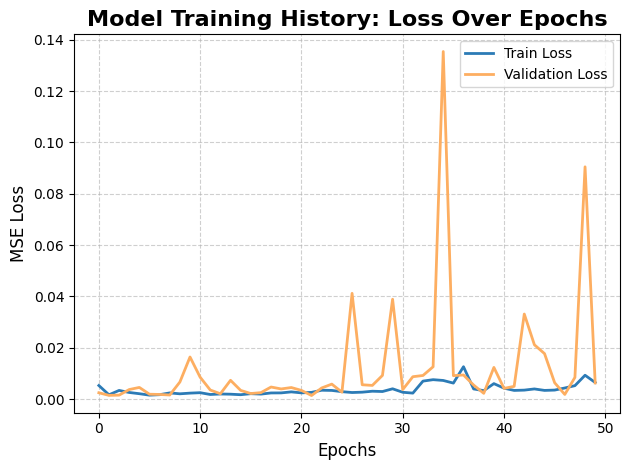

In [ ]:
history = history.history # only for original keras history object

# Use the 'history' object to plot the loss over time
plt.plot(history['loss'], label='Train Loss', color='#2c7bb6', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', color='#fdae61', linewidth=2)

# Apply aesthetics
plt.title('Model Training History: Loss Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust plot to prevent labels from overlapping
plt.show()

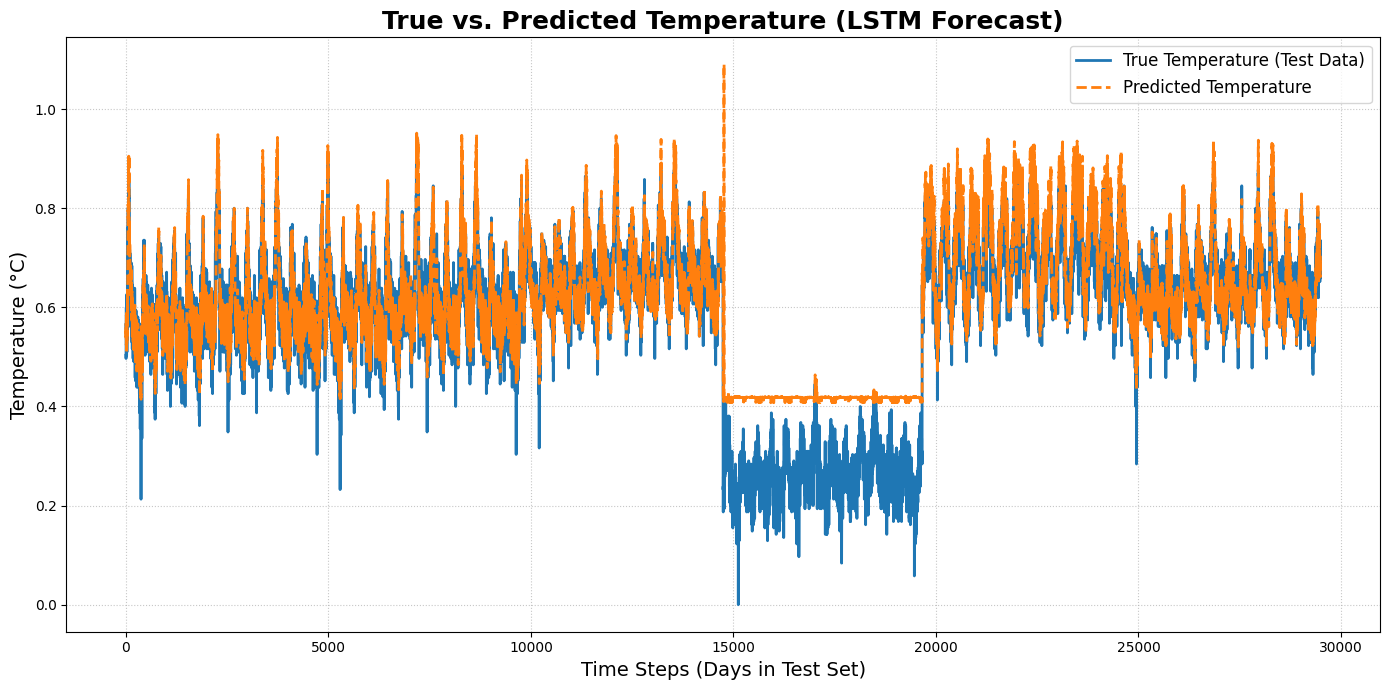

In [ ]:
### True vs predicted

plt.figure(figsize=(14, 7))

# Plot the actual true temperature values (Test Data)
plt.plot(y_test, label='True Temperature (Test Data)', color='#1f77b4', linewidth=2)

# Plot the predicted temperature values
plt.plot(y_pred, label='Predicted Temperature', color='#ff7f0e', linestyle='--', linewidth=2)

plt.title('True vs. Predicted Temperature (LSTM Forecast)', fontsize=18, fontweight='bold')
plt.xlabel('Time Steps (Days in Test Set)', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

### Save History and Model

In [ ]:
import datetime
import pickle

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")

# Save the history as a pickle file
with open(f'training_history_{timestamp}.pkl', 'wb') as file:
    pickle.dump(history, file)

model.save(f'lstm_temperature_forecast_{timestamp}.keras')
print("Model saved successfully.")